In [68]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from PIL import Image
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

In [47]:
data_path='./data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, shuffle=False
)

# #you can visualize it
import matplotlib.pyplot as plt
index = 0
for i in range(len(train_images)):
    img = train_images[index]
    #plt.imshow(img)
    mag_img = np.sqrt(np.sum(img**2))
    norm_img = np.sum(img/mag_img)
    #print(np.where(norm_img==np.nan))
    print(mag_img)
    index += 1



0.05105252359869703
0.057442861695516545
0.06177073441686731
0.052925316834403
0.06419815084392014
0.050003378203831286
0.05034036676018064
0.02705443878049202
0.05709970670837244
0.025330591803028085
0.05392642585758631
0.031957202363154726
0.06225748897509333
0.04680828791532576
0.06292536730688414
0.06097157877606061
0.04511525994126581
0.05860357466706959
0.06301450256434425
0.030728325357426575
0.06751206956363201
0.021712622957803608
0.03922190058639529
0.029325262476890532
0.07318225253853244
0.058402157553603964
0.03463813576663701
0.025969357245723256
0.050620987121199515
0.040300790616702845
0.04842090515433624
0.054518870613350326
0.05543694963135886
0.055287262462031236
0.04745601851194759
0.0682611214260461
0.06529461195409285
0.04486175969482117
0.049769067486701214
0.029288604893379408
0.049069664380558264
0.06561321081376775
0.027295564495914307
0.04886419642833706
0.03583628922888453
0.06115607049915607
0.04133600739669149
0.04197229139783979
0.011733877936643563
0.046

In [4]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 0, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

In [69]:
def conv_circuit(params):
    """
    params is a parameter vector
    """
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# # Let's draw this circuit and see what it looks like
# params = ParameterVector("θ", length=3)
# circuit = conv_circuit(params)
# circuit.draw("mpl")

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
        #print('qi',q1,'q2',q2)
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# circuit = conv_layer(4, "θ")
# circuit.decompose().draw("mpl", fold=100)


def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# params = ParameterVector("θ", length=3)
# circuit = pool_circuit(params)
# circuit.draw("mpl")


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# sources = [0, 1] # qubits from which information will be 'transferred'
# sinks = [2, 3] #qubits to which transferred information will be encoded
# circuit = pool_layer(sources, sinks, "θ")
# circuit.decompose().draw("mpl")

In [5]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# def understand_np_dot_roll():
#     arr = np.random.randint(1, 9, 16).reshape(4,4) * np.identity(4)
#     print("Random matrix generated\n", arr)
#     print("Shifting image by 1 in axis=1(x-axis)\n", np.roll(arr, 1, axis=1))
#     print("Shifting image by 1 in axis=1(x-axis) and by 1 in axis=0(y-axis) \n", np.roll(arr, (1,1), axis=(0,1)))
# understand_np_dot_roll()

8 initialised for this image


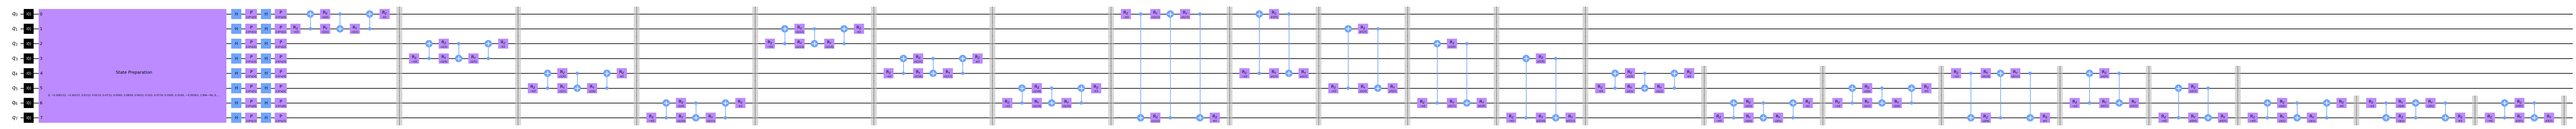

In [85]:
#submission to part 1, you should make this into a .py file
n=len(images)
mse=0
gatecount=0

def amplitude_encode(img_data):
    # Calculate the RMS value
    img_w, img_h = img_data.shape[0], img_data.shape[1]
    pixel_num = img_w*img_h
    rms = np.sqrt(np.sum(img_data**2))
    return (img_data/rms).reshape(pixel_num), rms, pixel_num

def plot_image(img, title='Reconstructed image'):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
def encode(image):
    image_norm_h, rms, pixel_num = amplitude_encode(image)
    num_qubits = int(np.log2(pixel_num))
    print(f"{num_qubits} initialised for this image")
    qc_h = QuantumCircuit(num_qubits)
    qc_h.initialize(image_norm_h, range(0, num_qubits))
    return qc_h, rms, num_qubits

def simulate(circuit, show_histogram=True):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.get_statevector()
    probabilities = np.array(np.abs(statevector)**2)
    if show_histogram:
        plt.bar(range((2**circuit.num_qubits)), probabilities)
        plt.xlabel('Basis State')
        plt.ylabel('Probability')
        plt.show()
    return probabilities

def decode(probabilities, rms):
    prob_sqrt = np.sqrt(probabilities)
    reconstructed_image = prob_sqrt * rms
    dim = int(np.sqrt(len(reconstructed_image)))
    return reconstructed_image.reshape(dim, dim)

def run_part1(image):
    #encode image into a circuit
    circuit, rms, num_qubits = encode(image)

    #simulate circuit
    histogram=simulate(circuit, show_histogram=False)

    #reconstruct the image
    image_re=decode(histogram, rms)

    return circuit,image_re, num_qubits 

img2 = Image.fromarray(train_images[0])
resized_dimention = 16
img2 = np.array(img2.resize((resized_dimention, resized_dimention)))
circuit, test_image, num_qubits = run_part1(img2)

qubits_list = list(range(num_qubits))
feature_map = ZFeatureMap(num_qubits)  # initialise feature map to capture total pixels

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), qubits=list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)
   

#print(ansatz.parameters)
circuit.compose(feature_map, range(8), inplace=True)
#circuit.append(feature_map, range(num_qubits))
circuit.compose(ansatz, range(8), inplace=True)
#circuit.append(ansatz, range(num_qubits))

circuit.decompose().draw("mpl", fold=-1)

# circuit2, test_image2 = run_part1(img.T)
#plot_image(test_image)


784


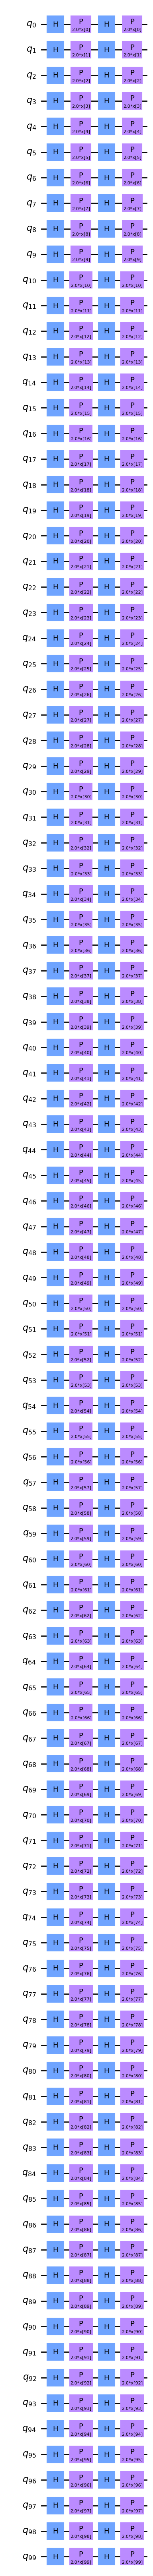

In [7]:
#how we grade your submission

n=len(images)
mse=0
gatecount=0

for data in images:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices